In [140]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

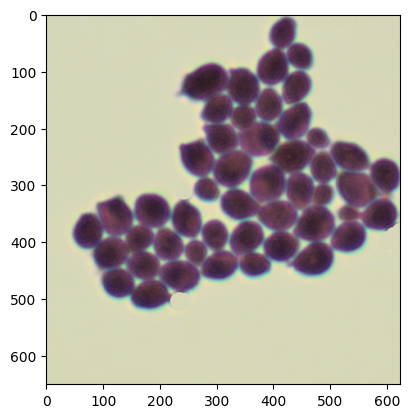

In [141]:
image_name = "./dataset/png/Candida.albicans_0008.png"
image = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
plt.imshow(image)

* K-means clustering

Ref: https://machinelearningknowledge.ai/image-segmentation-in-python-opencv/ \
Doc K-means: https://docs.opencv.org/3.4/d1/d5c/tutorial_py_kmeans_opencv.html

In [142]:
#Target class number
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3 #Trying to find BG / general contours / bacteria
attempts = 10

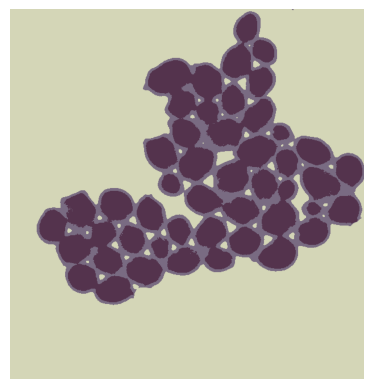

In [143]:
image_as_array = np.float32(image.reshape((-1,3)))

compactness, label, center = cv2.kmeans(image_as_array, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((image.shape))

plt.axis('off')
plt.imshow(result_image)

In [144]:
from cv2 import Mat

def execute_kmeans(image: Mat) -> Mat:
    image_as_array = np.float32(image.reshape((-1,3)))

    _, label, center = cv2.kmeans(image_as_array, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((image.shape))

    return result_image

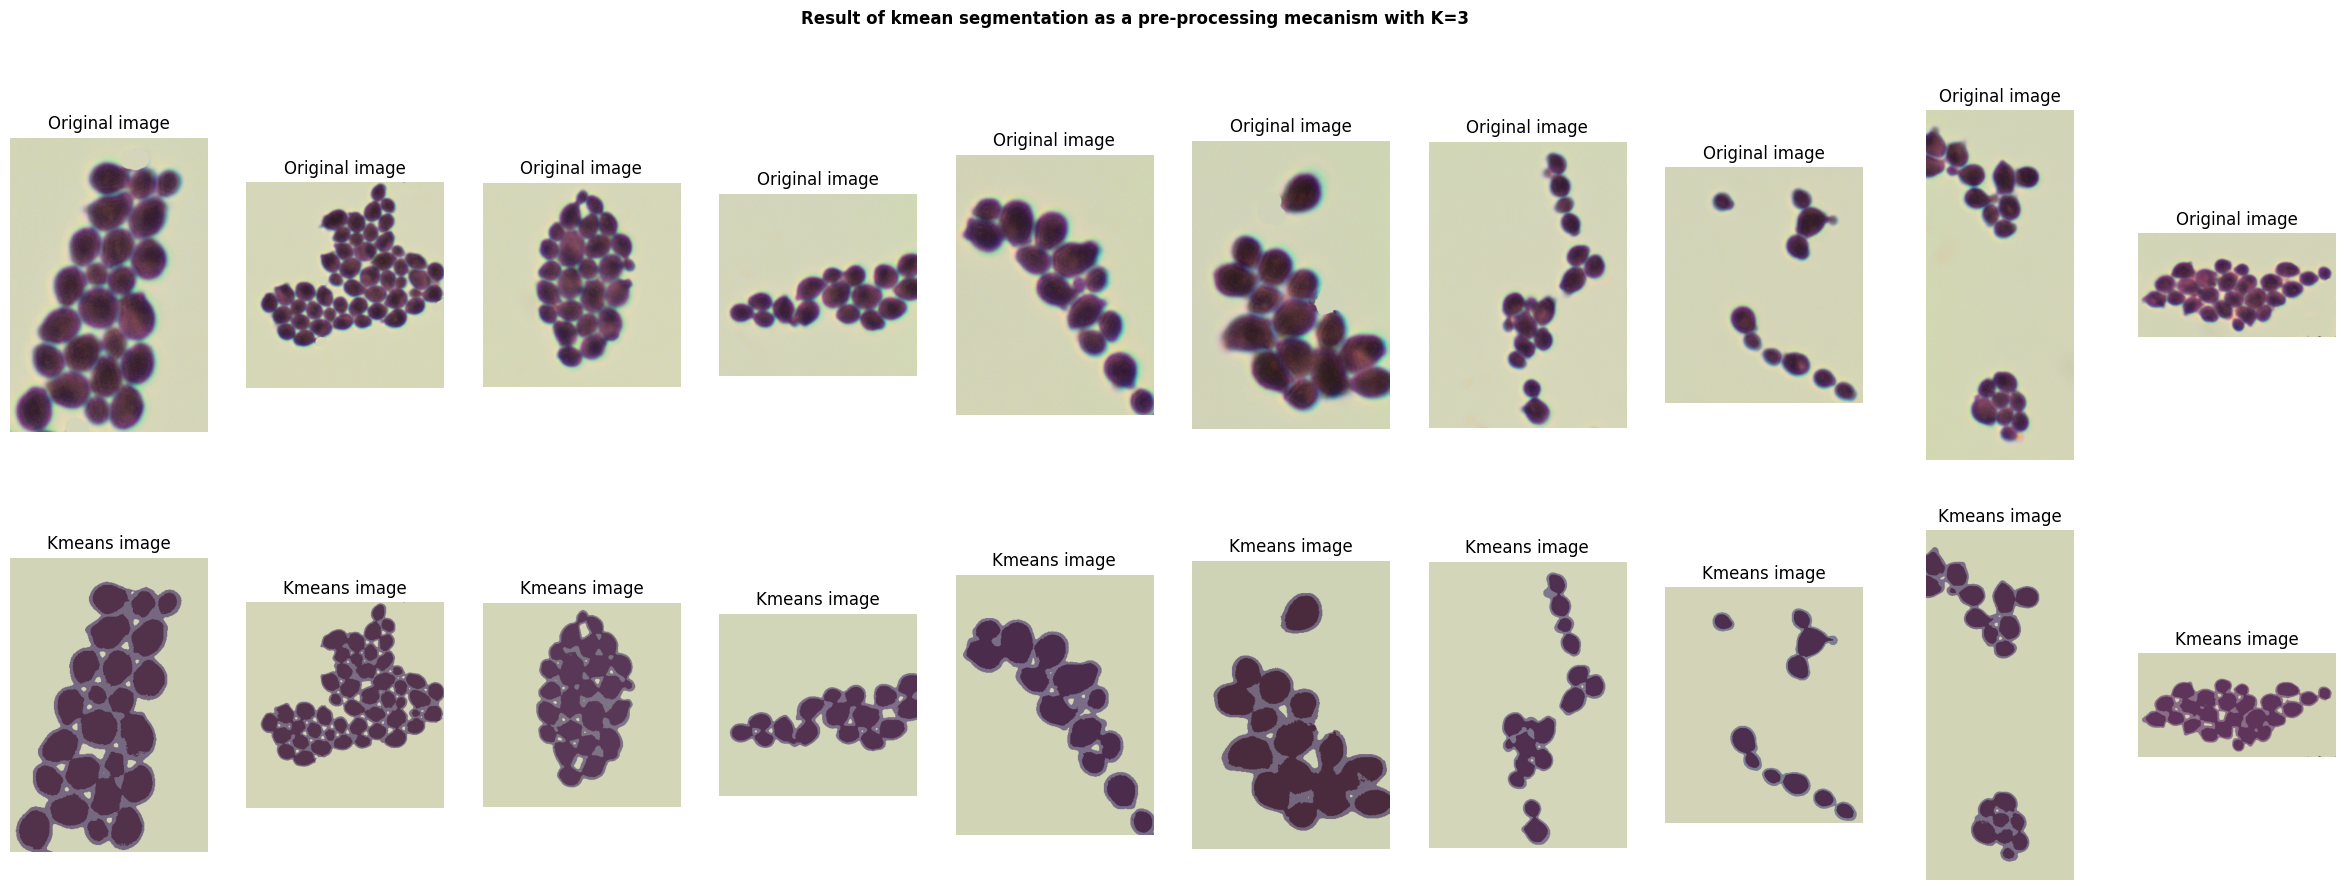

In [145]:
from os import listdir
FOLDER_PATH = "./dataset/png"

# Compute all images
kmean_images: list[tuple] = []
for file_name in listdir(FOLDER_PATH):
    image_name = f"{FOLDER_PATH}/{file_name}"
    original_image = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
    kmean_image = execute_kmeans(original_image)
    kmean_images.append((original_image, kmean_image))

#Display all kmeansed iamges
fig, ax = plt.subplots(2, len(kmean_images), figsize=(30, 10))
fig.suptitle(f'Result of kmean segmentation as a pre-processing mecanism with K={K}', fontweight='bold')

for i, (o_image, k_image) in enumerate(kmean_images):
    ax[0][i].imshow(o_image)
    ax[0][i].set_title('Original image')
    ax[0][i].set_axis_off()

    ax[1][i].imshow(k_image)
    ax[1][i].set_title('Kmeans image')
    ax[1][i].set_axis_off()

Remove ""noise"" between bacterias by detecting and suppressing middle channel

Centers found: 
[[ 84  51  77]
 [212 214 183]
 [121 107 130]]
Averages found: [70.66666666666667, 203.0, 119.33333333333333]
Detected center indexes: min=0, med=2, max=1


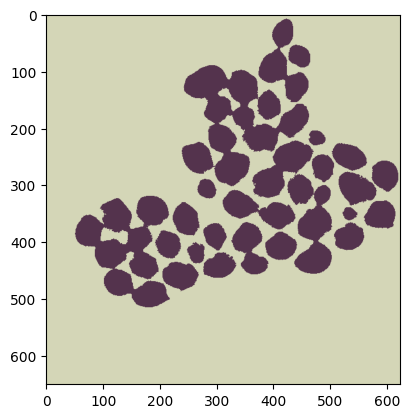

In [146]:
working_image = image.copy()

image_as_array = np.float32(working_image.reshape((-1,3)))

_, label, center = cv2.kmeans(image_as_array, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)

averages = [np.mean(c) for c in center]

print(f"Centers found: \n{center}")
print(f"Averages found: {averages}")

min_index = np.argmin(averages)
max_index = np.argmax(averages)
med_index = list(set((0,1,2)) - set((min_index, max_index)))[0]

print(f"Detected center indexes: min={min_index}, med={med_index}, max={max_index}")

#Suppress medium center directly in center array
center[med_index] = center[max_index] #Replace by background

res = center[label.flatten()]
suppressed_image = res.reshape((image.shape))
plt.imshow(suppressed_image)

Trivial binarization

(651, 623, 3)
uint8


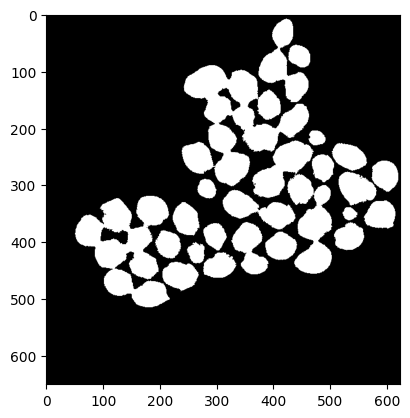

In [152]:
print(suppressed_image.shape)
print(suppressed_image.dtype)
gray_image = cv2.cvtColor(suppressed_image, cv2.COLOR_RGB2GRAY)
# blur = cv.GaussianBlur(img,(5,5),0)
_, binarized_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(binarized_image, cmap='gray', vmin=0, vmax=255)

Morphological

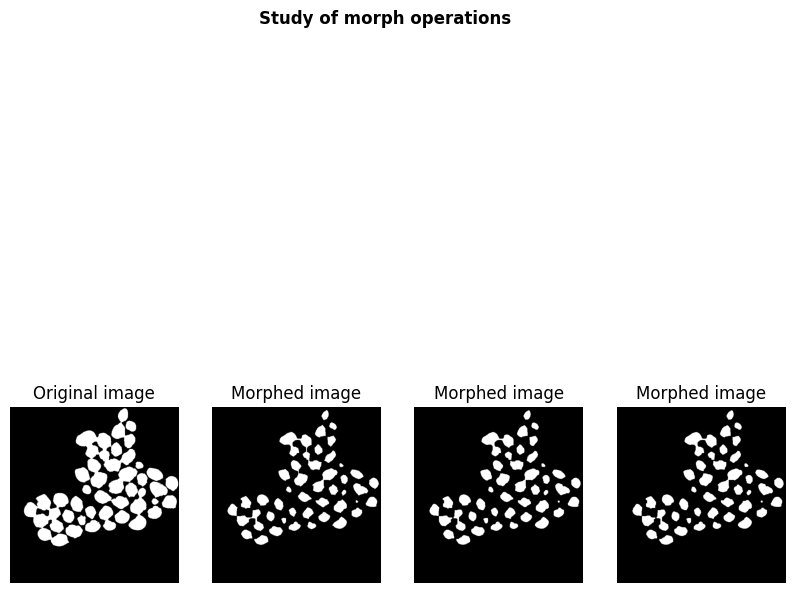

In [148]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
eroded_image = cv2.morphologyEx(binarized_image, cv2.MORPH_ERODE, kernel, iterations=5)
open_image = cv2.morphologyEx(eroded_image, cv2.MORPH_OPEN, kernel, iterations=2)
closed_image = cv2.morphologyEx(open_image, cv2.MORPH_CLOSE, kernel, iterations=1)

fig, ax = plt.subplots(1, 4, figsize=(20,10))
fig.suptitle(f'Study of morph operations', fontweight='bold')

ax[0].imshow(binarized_image, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original image')
ax[0].set_axis_off()

ax[1].imshow(eroded_image, cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Eroded image')
ax[1].set_axis_off()

ax[2].imshow(open_image, cmap='gray', vmin=0, vmax=255)
ax[2].set_title('Opened image')
ax[2].set_axis_off()

ax[3].imshow(closed_image, cmap='gray', vmin=0, vmax=255)
ax[3].set_title('Closed image')
ax[3].set_axis_off()

final_morphed_image = closed_image

Edge detection

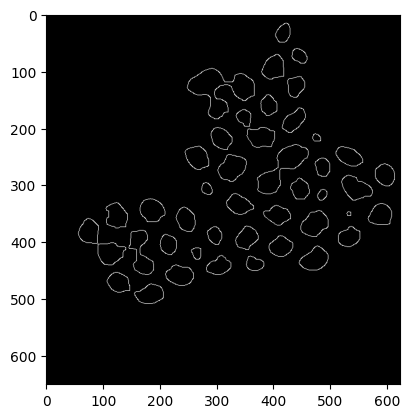

In [149]:
img_blur = cv2.GaussianBlur(final_morphed_image, (3,3), 0)
canny_img = cv2.Canny(img_blur, 0, 255)

plt.imshow(canny_img, cmap='gray', vmin=0, vmax=255)

Contour detection

Number of Contours found = 46


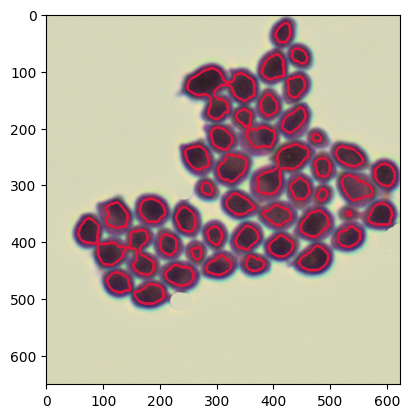

In [150]:
RED_RGB = (220,20,60)
GREEN_RGB = (0,255,0)

contours, hierarchy = cv2.findContours(canny_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

contoured_image = image.copy()

cv2.drawContours(image, contours, -1, RED_RGB, 3)
plt.imshow(image)
print("Number of Contours found = " + str(len(contours)))